In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy .linalg import svd
import torch
from torch import nn
import opinf
%load_ext autoreload
%autoreload 2

/mnt/d/PIML/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [18]:
%reload_ext autoreload
import helper_funcs as hf

#### 1D Heat Eqn Data

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001
shape of A:	(127, 127)
shape of q0:	(127,)
shape of Q: (127, 1001)


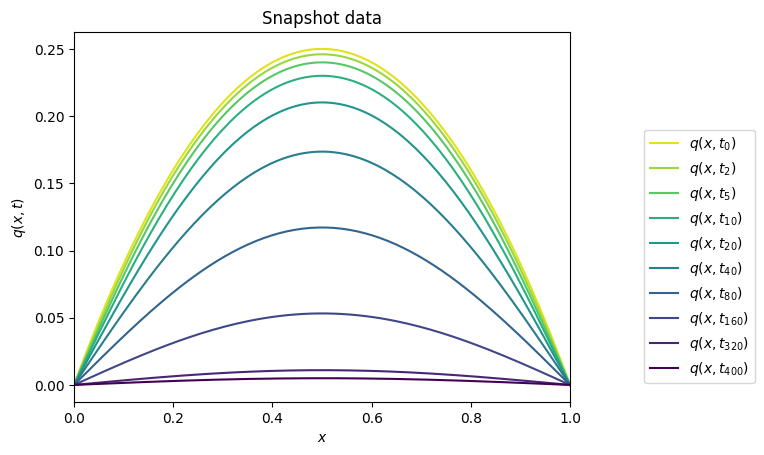

In [3]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
t0, tf = 0, 1                   # Initial and final time.
k = tf*1000 + 1                 # Temporal grid size.
t = np.linspace(t0, tf, k)      # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

# Construct the full-order state matrix A.
diags = np.array([1,-2,1]) / (dx**2)
A = sparse.diags(diags, [-1,0,1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
def fom(t, x):
    return A @ x

# Construct the initial condition for the training data.
q0 = x * (1 - x)

print(f"shape of A:\t{A.shape}")
print(f"shape of q0:\t{q0.shape}")

Q = solve_ivp(fom, [t0,tf], q0, t_eval=t, method="BDF", max_step=dt).y

print(f"shape of Q: {Q.shape}")

hf.plot_heat_data(Z=Q,dom=x_all, title="Snapshot data")

### Operator inference w/ OpInf Package

r = 5 singular values exceed 99.9999% energy
Shape of Vr: (127, 5)


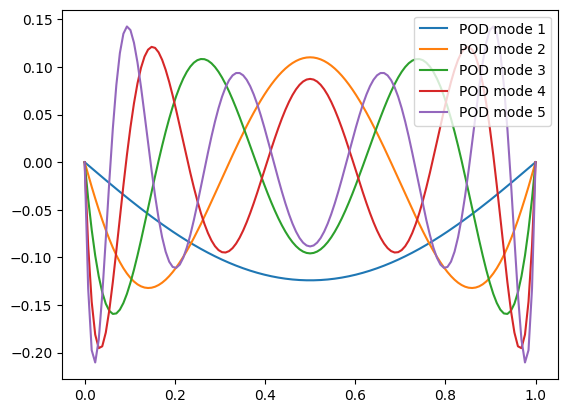

Reduced-order model structure: dq / dt = Aq(t)


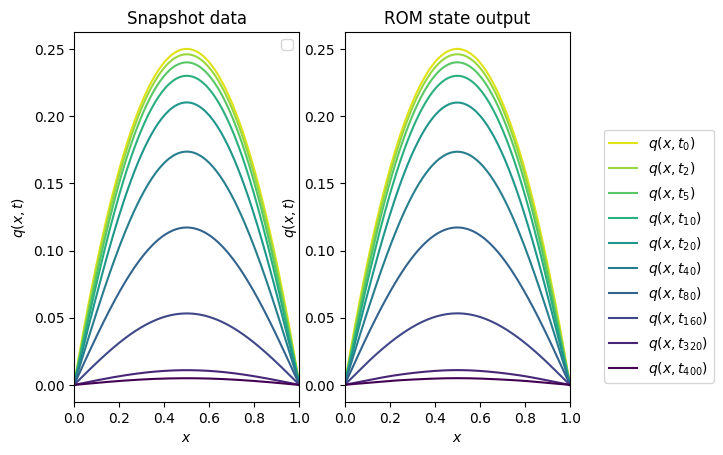

Mean Squared Error: 1.67e-09


In [25]:
svdvals = la.svdvals(Q)
kappa = .999999
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=False)
r=5
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")
Vr, _ = opinf.pre.pod_basis(Q, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")
for j in range(Vr.shape[1]):
    plt.plot(x_all, np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
    # plt.plot(x_all[1:-1], Vr[:,j], label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()
Qdot = opinf.pre.ddt_uniform(Q, dt, order=6)
rom = opinf.ContinuousOpInfROM("A")
print(rom)
rom.fit(basis=Vr, states=Q, ddts=Qdot)
rom.fit(Vr, Q, Qdot, solver=opinf.lstsq.L2Solver(regularizer=1e-2))
Q_ROM_Opinf = rom.predict(q0, t, method="BDF", max_step=dt)
fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,x_all, "Snapshot data",BCs=True, ax=ax1)
hf.plot_heat_data(Q_ROM_Opinf, x_all, "ROM state output", BCs=True, ax=ax2)
ax1.legend([])
plt.show()

print(f"Mean Squared Error: {np.mean((Q_ROM_Opinf-Q)**2):.2e}")

### Operator Inference from Scratch

Reduced Q shape   (5, 1001)
Original Q shape  (127, 1001)
dQ/dt shape (5, 1000)


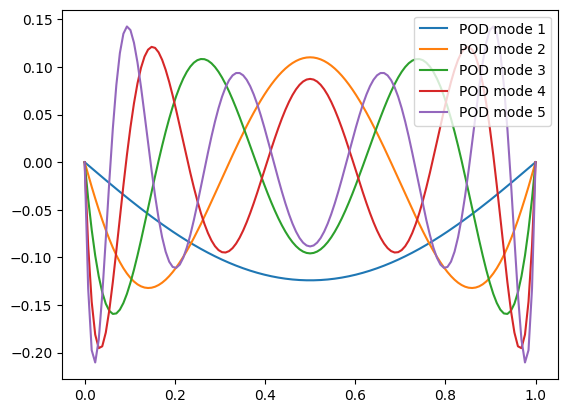

In [5]:
U, s, VT = svd(Q)
r = hf.optimal_svd_vecs(0.9999, s)
r = 5
Vr = U[:, :r]
Q_hat = np.linalg.multi_dot([np.transpose(Vr), Q])
print("Reduced Q shape  ", Q_hat.shape)
print("Original Q shape ", Q.shape)
Q_dot = Q_hat[:, 1:]-Q_hat[:, :Q_hat.shape[1]-1]
Q_dot = Q_dot/dt
print("dQ/dt shape", Q_dot.shape)

for i in range(r):
    plt.plot(x_all, np.concatenate(([0], Vr[:,i], [0])), label=f"POD mode {i+1}")

plt.legend()
plt.show()

In [6]:
def get_model(A, y, lamb=0):
    n_col = A.shape[1]
    return np.linalg.lstsq(A.T.dot(A) + lamb * np.identity(n_col), A.T.dot(y), rcond=None)

AT = get_model(Q_hat[:, :-1].T, Q_dot.T, lamb=1e-4)[0]
A_inf_np = AT.T

Q_ROM_scratch = hf.predict_from_scratch(AT.T, Q_hat[:, 0], Vr, t)

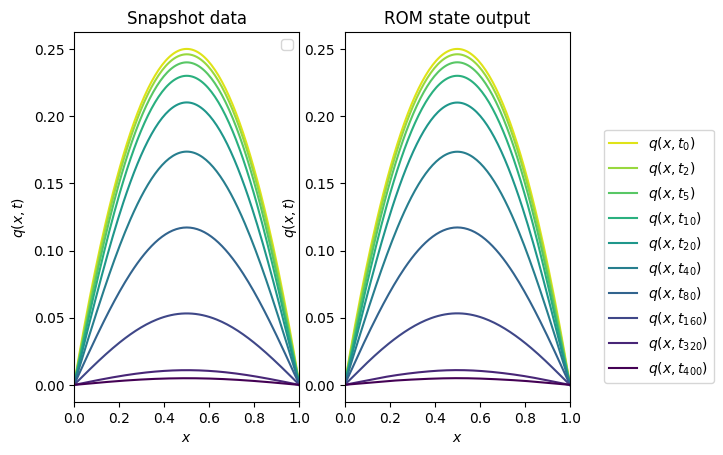

Mean Squared Error : 1.1897645714153355e-09


In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,x_all, "Snapshot data",BCs=True, ax=ax1)
hf.plot_heat_data(Q_ROM_scratch, x_all, "ROM state output", BCs=True, ax=ax2)
ax1.legend([])
plt.show()

print(f"Mean Squared Error :", np.mean((Q_ROM_scratch-Q)**2))


### Operator Inference w/ Torch

Reduced Q shape   (5, 1001)
Original Q shape  (127, 1001)
dQ/dt shape (5, 1000)


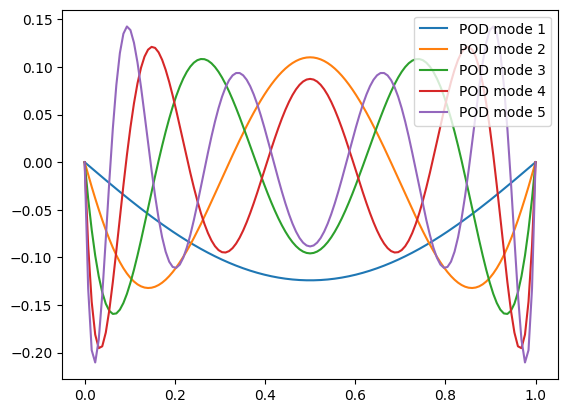

In [8]:
U, s, VT = svd(Q)
r = 5 # number of modes to keep
Vr = U[:, :r]
Q_hat = np.linalg.multi_dot([np.transpose(Vr), Q])
print("Reduced Q shape  ", Q_hat.shape)
print("Original Q shape ", Q.shape)
Q_dot = Q_hat[:, 1:]-Q_hat[:, :Q_hat.shape[1]-1]
Q_dot = Q_dot/dt
print("dQ/dt shape", Q_dot.shape)
for i in range(r):
    plt.plot(x_all, np.concatenate(([0], Vr[:,i], [0])), label=f"POD mode {i+1}")

plt.legend()
plt.show()

In [9]:
A_inf = hf.OpInfA_torch(r, r)

optimizer = torch.optim.Adam(A_inf.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
data = [Q_dot, Q_hat[:, :Q_hat.shape[1]-1] ]


hf.train_loop(optimizer, loss_fn, data, A_inf, n_epochs = 10000)

Q_ROM_Torch = hf.predict_from_torch(A_inf, Q_hat[:, 0], Vr, t)


Loss : 0.0003694698680192232
Loss : 3.138331157970242e-05
Loss : 4.3251247916487046e-06
Loss : 7.818644917279016e-06
Loss : 2.0120930344091903e-07


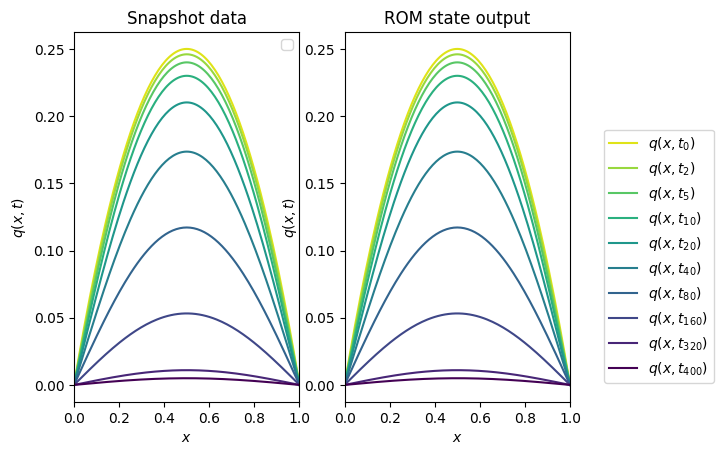

Mean Squared Error : 9.524102389379754e-14


In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2)
hf.plot_heat_data(Q,x_all, "Snapshot data",BCs=True, ax=ax1)
hf.plot_heat_data(Q_ROM_Torch, x_all, "ROM state output", BCs=True, ax=ax2)
ax1.legend([])
plt.show()

print(f"Mean Squared Error :", np.mean((Q_ROM_Torch-Q)**2))

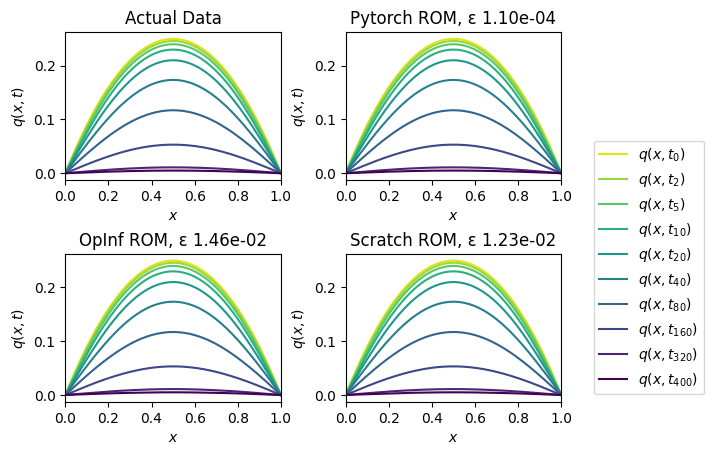

MSE w/ Torch, Adam : 9.524102389379754e-14
MSE w/ OpInf: 1.6739379879305362e-09
MSE w/ Scratch: 1.1897645714153355e-09


In [11]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
hf.plot_heat_data(Q,x_all, f"Actual Data",BCs=True, ax=ax1, legend=False)
hf.plot_heat_data(Q_ROM_Torch, x_all, f"Pytorch ROM, ε {hf.frobenius_norm_error(Q, Q_ROM_Torch):.2e}", BCs=True, ax=ax2, legend=False)
hf.plot_heat_data(Q_ROM_Opinf, x_all, f"OpInf ROM, ε {hf.frobenius_norm_error(Q, Q_ROM_Opinf):.2e}", BCs=True, ax=ax3, legend=False)
hf.plot_heat_data(Q_ROM_scratch, x_all, f"Scratch ROM, ε {hf.frobenius_norm_error(Q, Q_ROM_scratch):.2e}", BCs=True, ax=ax4, legend=True)
# ax1.legend([])
plt.show()

print(f"MSE w/ Torch, Adam :", np.mean((Q_ROM_Torch-Q)**2))
print(f"MSE w/ OpInf:", np.mean((Q_ROM_Opinf-Q)**2))
print(f"MSE w/ Scratch:", np.mean((Q_ROM_scratch-Q)**2))

### OperInf on Different Initial Conditions

#### $Q_0(x) = x^2(1-x)^2$

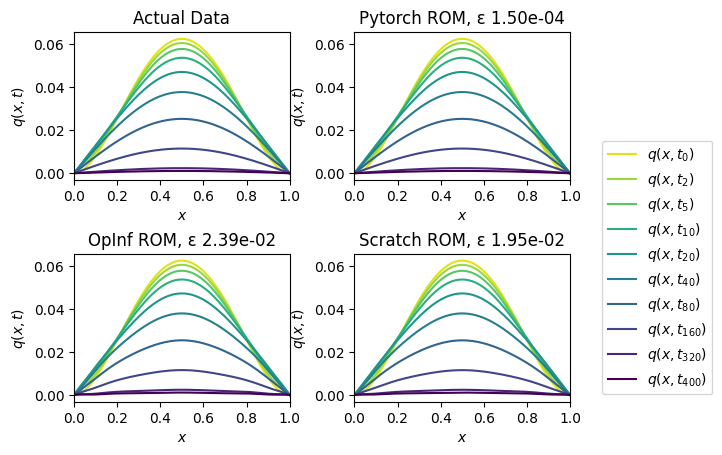

In [17]:
q_0 = x_all**2 * (1 - x_all)**2
hf.compare(q_0, Vr, fom, rom, A_inf, AT, x_all, t)


#### $Q_0(x) = \sqrt{x(1-x)}$

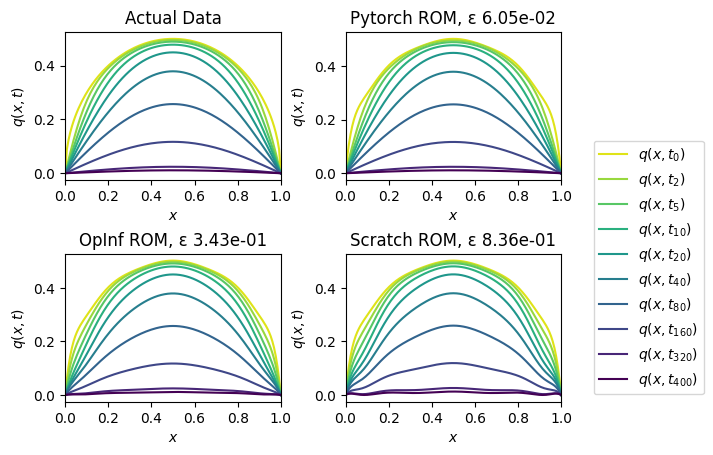

In [21]:
q_0 = np.sqrt(x_all*(1-x_all))
hf.compare(q_0, Vr, fom, rom, A_inf, AT, x_all, t)

#### $Q_0(x) = sin(Πx) + \frac{1}{5}sin(5Πx)$

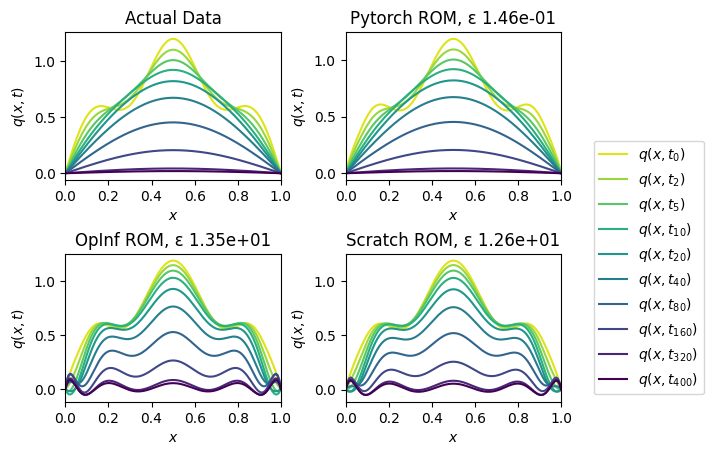

In [22]:
q_0 = np.sin(np.pi*x_all) + 1/5 * np.sin(5*np.pi*x_all)
hf.compare(q_0, Vr, fom, rom, A_inf, AT, x_all, t)